# Topology Vietoris–Rips Coverage
In this Google colab we are going to use two text files that list edges to a graph. We need to determine if there is a 1-cycle $\gamma$.


## Step 1: Setup
First we install common pages and the data files.

In [ ]:
import numpy as np #Library for linear algebra (vectors and matricies)
from numpy.linalg import inv
import pandas as pd #Pandas for DataFrame objects
import math,random,json,statistics #Commonly used packages
from collections import defaultdict #Better dictionary for mapping
import matplotlib.pyplot as plt #For plotting
import networkx as nx
import warnings
from scipy import linalg
warnings.simplefilter(action='ignore', category=FutureWarning)

Now we download the data files from a static source.

# Prepare Datasets

## Downloading using `wget`
We placed the datasets on a statically hosted website. We use the command `wget` to retrieve them. From the `man` pages of `wget`:
```
Wget - The non-interactive network downloader.
```
Downloads the files and places them in the root directory of our program for IO.



### Download Robot Datasets

In [ ]:
%%capture
!wget https://gradstudent.me/public/robotdata1.txt
!wget https://gradstudent.me/public/robotdata2.txt

Now the text datasets `robotdata_1.txt` and `robot_data2.txt` are loaded into the notebook and ready for parsing.

## Parsing Raw Data to DataFrame
We use panda's `read_csv` function to import the datasets into python as `DataFrame` objects.

In [ ]:
robot_data_1 = pd.read_csv("robotdata1.txt",delim_whitespace=True,names=['a','b'])
robot_data_2 = pd.read_csv("robotdata2.txt",delim_whitespace=True,names=['a','b'])

## Converting to Numpy Arrays
Since we are going to process the data element by element it is easier to manipulate as a numpy array instead of a dataframe. Here we convert the datasets into the numpy arrays:
 - `all_edges_1` from the first dataset
 - `all_edges_2` from the second dataset. 

In [ ]:
#Convert to vector of edges
all_edges_1 = np.array([robot_data_1['a'],robot_data_1['b']]).T
all_edges_2 = np.array([robot_data_2['a'],robot_data_2['b']]).T

print(f"Shape of first list {all_edges_1.shape}:(rows,columns)")
print(f"Shape of second list {all_edges_2.shape}:(rows,columns)")
print(f"Exmaple of edges: {all_edges_1.tolist()[:5]}")

Shape of first list (100, 2):(rows,columns)
Shape of second list (104, 2):(rows,columns)
Exmaple of edges: [[1, 2], [1, 11], [1, 20], [1, 27], [2, 3]]


## Initial Graphical Display
We use the NeworkX pakage to display the graphs.

Left (orange) is Robots_1	Right (cyan) is Robots_2


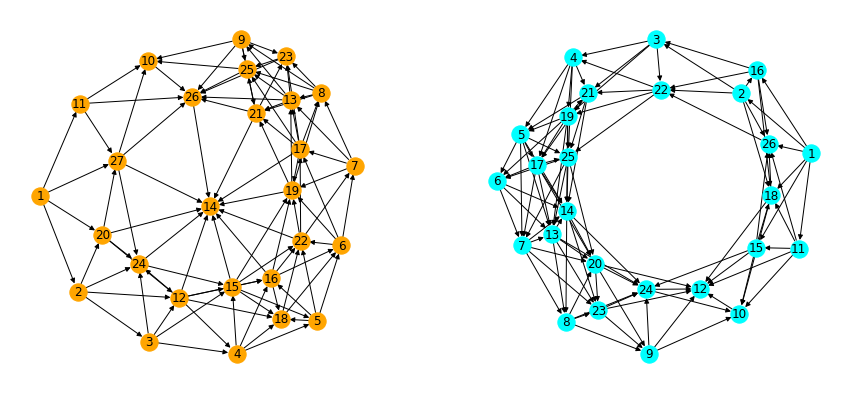

In [ ]:
def graph_edges(edges,**kwargs):
  graph = nx.Graph()
  graph.add_edges_from(edges)
  nx.draw(graph,with_labels=True,arrows=True,arrowstyle='-|>',**kwargs)

#Making a big figure to see the graph
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
graph_edges(all_edges_1,node_color='orange')
plt.subplot(1,2,2)
graph_edges(all_edges_2,node_color='cyan')
print("Left (orange) is Robots_1\tRight (cyan) is Robots_2")

## Calculating the number of robots
Here we look at the arrays to find the total number of robots.

In [ ]:
robot_ids_1 = set(np.hstack([all_edges_1[:,0],all_edges_1[:,1]]))
robot_ids_2 = set(np.hstack([all_edges_2[:,0],all_edges_2[:,1]]))
n_robots_1 = len(robot_ids_1)
n_robots_2 = len(robot_ids_2)
print(f'Number of robots in first list is {n_robots_1}.')
print(f'Number of robots in second list is {n_robots_2}.')

Number of robots in first list is 27.
Number of robots in second list is 26.


## Finding Triangles
What we need to do is use the edges to find all the $\sigma_i$ triangles formed in the dataset.

We do this by making a mapping of vertex to directed edges called `mapping` then using it to look for looks like, 
\begin{align*}
  [a,b,c] = [a,b] + [b,c] - [c,a]
\end{align*}
Or the alternative form,
\begin{align*}
  [a,b,c] = [b,c] - [a,c] + [a,b].
\end{align*}

In [ ]:
def get_edge_mappings(edges: list) -> dict:
  mapping = defaultdict(list)
  positive_mapping = defaultdict(list)
  negative_edges = [[b,a] for a,b in edges]
  for a,b in edges:
    positive_mapping[a].append(b)
    mapping[a].append(b)
  for a,b in negative_edges:
    mapping[a].append(b)
  return dict(positive_mapping),edges

In [ ]:
edge_map_1,edges_1 = get_edge_mappings(all_edges_1)
edge_map_2,edges_2 = get_edge_mappings(all_edges_2)
edge_map_2

{1: [2, 11, 15, 16, 18, 26],
 2: [3, 16, 18, 22, 26],
 3: [4, 16, 19, 21, 22],
 4: [5, 17, 19, 21, 22, 25],
 5: [6, 7, 13, 14, 17, 19, 21, 25],
 6: [7, 13, 14, 17, 19, 25],
 7: [8, 13, 14, 17, 20, 23, 25],
 8: [9, 13, 14, 20, 23, 24],
 9: [10, 12, 20, 23, 24],
 10: [11, 12, 15, 18, 24],
 11: [12, 15, 18, 26],
 12: [15, 18, 20, 23, 24],
 13: [14, 17, 19, 20, 23, 24, 25],
 14: [17, 19, 20, 21, 23, 24, 25],
 15: [18, 24, 26],
 16: [18, 22, 26],
 17: [19, 20, 21, 25],
 18: [26],
 19: [21, 22, 25],
 20: [23, 24, 25],
 21: [22, 25],
 22: [25, 26],
 23: [24]}

Now we search and build a list of triangles (2-cycles).

In [ ]:
#Given a dictionary list of connections return all 2-cycles
# Missing [1,11,27]
def get_triangles(edge_mapping: dict) -> list:
  heads = edge_mapping.keys()
  output = [] #List of triangles
  for a,a_values in edge_mapping.items():
    for b in a_values:
      """
      if b in heads:
        b_values = edge_mapping[b]
        for c in b_values:
          if c in heads and c in a_values:
            output.append((a,b,c))
      """
      #New version
      for c in a_values:
        if c in heads:
          c_values = edge_mapping[c]
          if b in c_values:
            output.append((a,c,b))
      #
  return output

#Find the 2-cycles
triangles_1 = get_triangles(edge_map_1)
triangles_2 = get_triangles(edge_map_2)
print(f"Found {len(triangles_1)} total Triangles in Dataset 1")
print(f"Found {len(triangles_2)} total Triangles in Dataset 2")
triangles_1[:5]

Found 136 total Triangles in Dataset 1
Found 169 total Triangles in Dataset 2


[(1, 2, 20), (1, 11, 27), (1, 20, 27), (2, 3, 12), (2, 12, 20)]

Next we define the $\partial_1$ and its inverse operator on a triangle.

In [ ]:
def delta_1(triangle):
  a,b,c = triangle
  return [(b,c),(a,c),(a,b)]

#Given edges bc - ac + ab return [a,b,c]
def inverse_delta_1(bc,ac,ab):
  a,b = ab
  _,c = bc
  return (a,b,c)

Next we generate the image of $\hat \partial_1$.

Example - Triangle: (1, 2, 20)	 Edges: [(2, 20), (1, 20), (1, 2)]
Example - Triangle: (1, 11, 27)	 Edges: [(11, 27), (1, 27), (1, 11)]
Example - Triangle: (1, 20, 27)	 Edges: [(20, 27), (1, 27), (1, 20)]


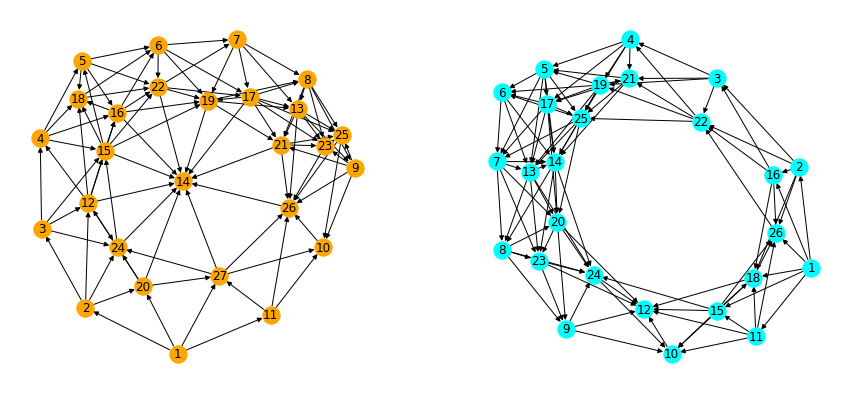

In [ ]:
image_1 = [delta_1(triangle) for triangle in triangles_1]
image_2 = [delta_1(triangle) for triangle in triangles_2]
for triangle,image in zip(triangles_1[:3],image_1[:3]):
  print(f"Example - Triangle: {triangle}\t Edges: {image}")

#Making a big figure to see the graph
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
graph_edges(all_edges_1,node_color='orange')
plt.subplot(1,2,2)
graph_edges(all_edges_2,node_color='cyan')

Now we search in the image for the fence.

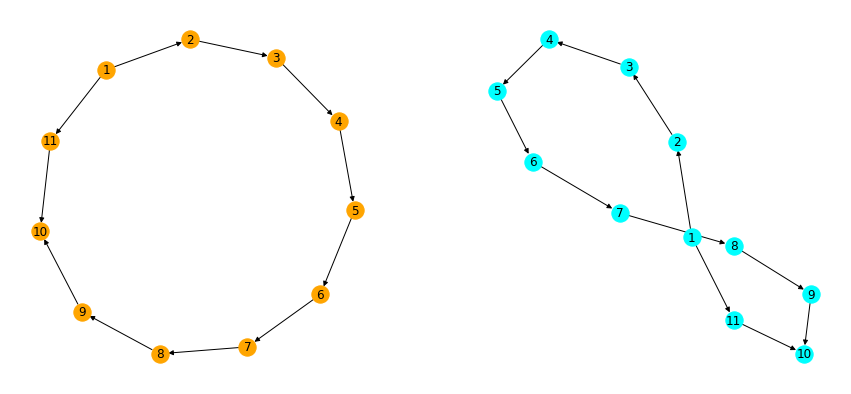

In [ ]:
def get_fence(fence_ids: list, edges: list) -> list:
  fence = []
  for a,b in edges:
    if b-a==1 and b in fence_ids: 
      fence.append((a,b))
    elif a==fence_ids[0] and b==fence_ids[-1]:
      #Last edge is reversed
      fence.append((a,b))
  return fence

fence_ids = range(1,11+1) #{1,...,11}
fence_1 = get_fence(fence_ids, all_edges_1)
fence_2 = get_fence(fence_ids, all_edges_2)

#Graph the fence
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
graph_edges(fence_1,node_color='orange')
plt.subplot(1,2,2)
graph_edges(fence_2,node_color='cyan')

## Building the Middle Matrix
Each column is a vector the border of a directional simplex. The rows are the mapping to the edges.

In [ ]:
def get_triangle_edge_indexes(edges,triangle):
  if isinstance(edges,np.ndarray):
    edges = edges.tolist()
  indexes = []
  for a,b in delta_1(triangle):
    if [a,b] in edges:
      indexes.append(edges.index([a,b]))
    elif [b,a] in edges:
      indexes.append(edges.index([b,a]))
    else:
      print(f"Missing [{a},{b}] and [{b},{a}] in edges")
  return indexes

def get_connection_matrix(edges,triangles):
  connections = np.zeros((len(triangles),len(edges)))
  for j,triangle in enumerate(triangles):
    indexes = get_triangle_edge_indexes(edges,triangle)
    for i,index in enumerate(indexes):
      connections[j-1,index]=1 if i!=1 else -1
  connections = connections.T
  return connections

connections_1 = get_connection_matrix(all_edges_1,triangles_1)
connections_2 = get_connection_matrix(all_edges_2,triangles_2)

### Visualizing the matrix

First dataset's shape: (100, 136)
Second dataset's shape: (104, 169)


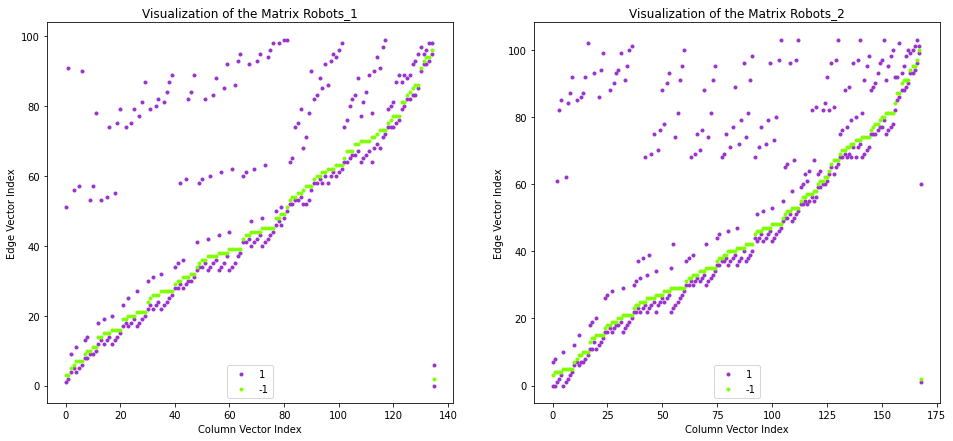

In [ ]:
def plot_big_matrix(matrix,title=""):
  #plt.scatter(x,y,color='black',alpha=.05,marker='.',label="0")
  positive = []
  negative = []
  for i,col in enumerate(matrix.T):
    for j,cell in enumerate(col):
      if cell==1:
        positive.append([i,j])
      elif cell==-1:
        negative.append([i,j])
      elif cell != 0:
        print(cell)
  x,y = zip(*positive)
  plt.scatter(x,y,color='darkorchid',marker='.',label="1")
  x,y = zip(*negative)
  plt.scatter(x,y,color='chartreuse',marker='.',label="-1")

  plt.legend(loc="lower center")

  #plt.grid()
  plt.xlabel("Column Vector Index")
  plt.ylabel("Edge Vector Index")
  plt.title(f"Visualization of the Matrix {title}")

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plot_big_matrix(connections_1, "Robots_1")
plt.subplot(1,2,2)
plot_big_matrix(connections_2, "Robots_2")
print(f"First dataset's shape: {connections_1.shape}")
print(f"Second dataset's shape: {connections_2.shape}")
plt.show()

### Edge Vector
Make edge vector

In [ ]:
def plot_vector(vector,title,**kwargs):
  plt.scatter(range(len(vector)),vector,**kwargs)
  plt.title(title)
  plt.xlabel("Index")
  plt.ylabel("Magnitude")

Shape Edge Vector 1 (100,)
Shape Edge Vector 2 (104,)


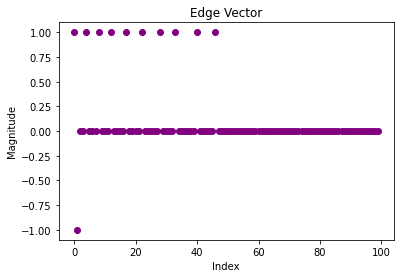

In [ ]:
def get_edge_vector(edges):
  edges = edges.tolist()
  edge_vector = np.zeros(len(edges))
  for (a,b) in fence_1:
    if [a,b] == [1,11]:
      edge_vector[edges.index([a,b])]=-1
    else:
      edge_vector[edges.index([a,b])]=1
  return edge_vector


edge_vector_1 = get_edge_vector(edges_1)
edge_vector_2 = get_edge_vector(edges_2)
print(f"Shape Edge Vector 1 {edge_vector_1.shape}")
print(f"Shape Edge Vector 2 {edge_vector_2.shape}")
plot_vector(edge_vector_1,"Edge Vector",color="purple")

We solve the linear system of equations, 
\begin{align*}
  E = MA
\end{align*}

$M$ is not-square and singular. To solve it we use Pivoted $QR$-Decomposition of $M$ to produce,
\begin{align*}
  M = QRP^T
\end{align*}
Where $Q$ is is a square orthogonal matrix, $R$ is an upper right triangle matrix and $P$ is a permutation matrix.

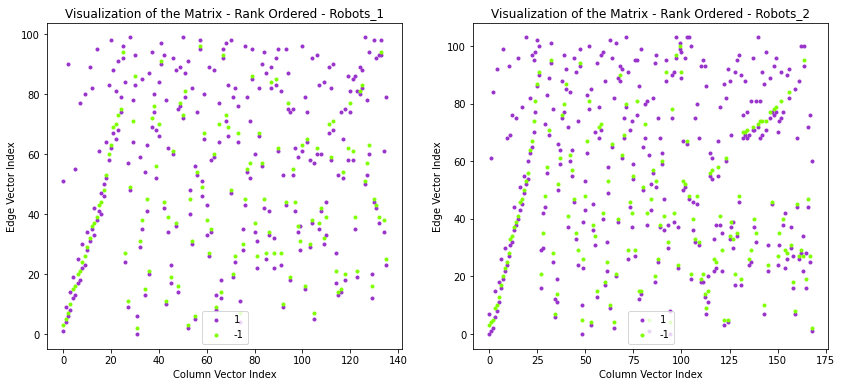

In [ ]:
def rank_reveal_QR(triangle_space):
  M = triangle_space.copy()
  Q,R,P= linalg.qr(M,pivoting=True)
  P = np.eye(len(P))[:,P] #make pivot matrix
  M_o = M_ordered = M@P #Re-order triangle matrix
  return Q,R,P,M_o
*qrp_1,M_1 = rank_reveal_QR(connections_1)
*qrp_2,M_2 = rank_reveal_QR(connections_2)

#Plot ordered matricies
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_big_matrix(M_1,"- Rank Ordered - Robots_1")
plt.subplot(1,2,2)
plot_big_matrix(M_2,"- Rank Ordered - Robots_2")

In [ ]:
#Define functions to get soultion vector using QR Factorization and backward substitution
#Ref: https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/l_lineqs_solving.html
def get_solution(Q,R,P,M,y):
  rank = np.linalg.matrix_rank(M)
  Q_1 = Q[:,:rank]
  R_1 = R[:rank,:rank]
  R_2 = R[:,:-(rank-Q.shape[1])]
  print("R_1,R_2,Q_1,y,P:",R_1.shape,R_2.shape,Q_1.shape,y.shape,P.shape)
  z_1 = inv(R_1)@Q_1.T@y
  zeros = np.zeros((P.shape[0]-z_1.shape[0])) #padding
  x = P@np.hstack([z_1,zeros])

  #Method to find affine set of all solutions
  """
  y_n = inv(R_1)@Q_1.T@R_2
  zeros = np.zeros([P.shape[0]-y_n.shape[0],y_n.shape[1]]) #padding
  L = -P@np.vstack([y_n,zeros])
  adjusts =  [l_0 for l_0 in np.ptp(L,axis=1) if np.allclose(M@(x + l_0),y)]
  solutions = [x + l_0 for l_0 in np.ptp(L,axis=1) if np.allclose(M@(x + l_0),y)]
  print(f"Number of solutions {len(solutions)}")
  """
  return x

#Test a given solution x against in y=Mx
#kwargs is for plotting options
#Return True is the solution is correct
def check_solution(y,M,x,**kwargs):
  sol = M@x
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plot_vector(sol,"Evaluation of Potential Solution ($E=MA$)",**kwargs)

  plt.subplot(1,2,2)
  plot_vector(y,"Edge Vector (E)",**kwargs)
  return np.allclose(y,sol)

R_1,R_2,Q_1,y,P: (74, 74) (100, 26) (100, 74) (100,) (136, 136)


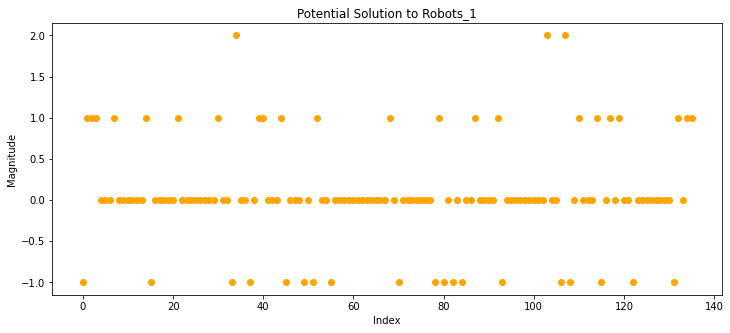

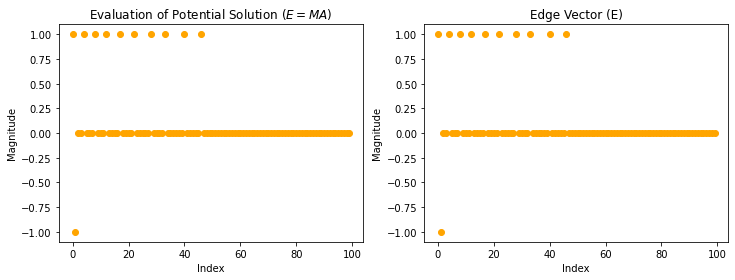

Robots_1 has a solution!


In [ ]:
#Get solution through QR Factorization
x_1 = get_solution(*qrp_1,connections_1,edge_vector_1)

#Plot solution
plt.figure(figsize=(12,5))
plot_vector(x_1,"Potential Solution to Robots_1",color="orange")
plt.show()

#Test solution vector
solution_exists = check_solution(edge_vector_1,connections_1,x_1,color="orange")
plt.show()
print("Robots_1 has a solution!") if solution_exists else print("Robots_1 has no solution!")

R_1,R_2,Q_1,y,P: (78, 78) (104, 26) (104, 78) (104,) (169, 169)


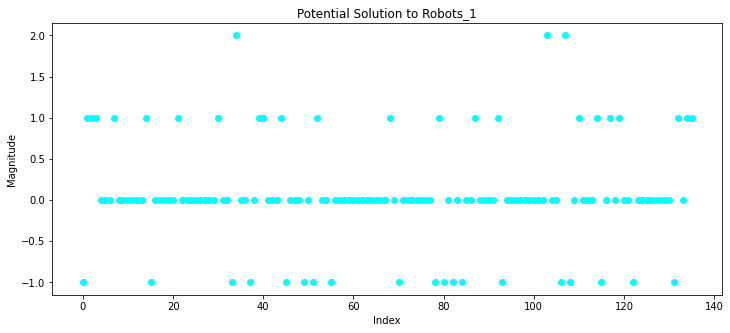

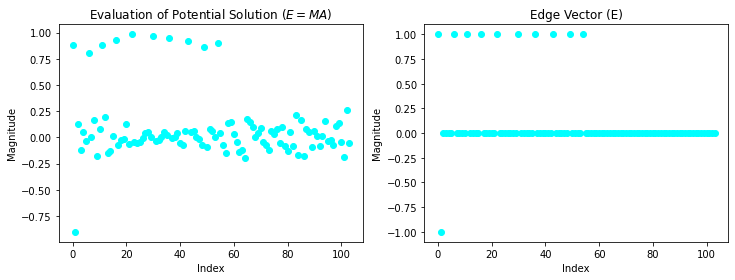

Robots_2 has no solution!


In [ ]:
#Get solution through QR Factorization
x_2 = get_solution(*qrp_2,connections_2,edge_vector_2)

#Plot solution
plt.figure(figsize=(12,5))
plot_vector(x_1,"Potential Solution to Robots_1",color="cyan")
plt.show()

#Test solution vector
solution_exists = check_solution(edge_vector_2,connections_2,x_2,color="cyan")
plt.show()
print("Robots_2 has a solution!") if solution_exists else print("Robots_2 has no solution!")

## Graph Plotting Solution
To see if any of this is working lets try to draw the graph.

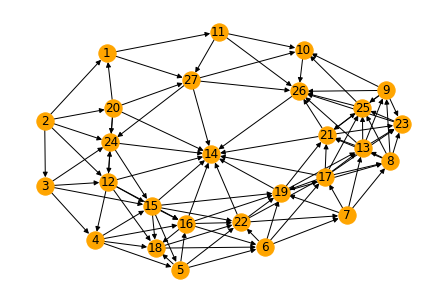

In [ ]:
#Plotting solution of Robots_1
solution_edges = [edge for i,_ in enumerate(x_1) for edge in delta_1(triangles_1[i])]
graph_edges(solution_edges,node_color='orange')

In [ ]:
#Draws a spiral
def spiral(N,speed=3):
    points = []
    for i in range(N):
        r = (N-i+N/speed)/(N+N/speed)
        x = r*math.cos(5*math.pi/N*i)
        y = r*math.sin(5*math.pi/N*i)
        points.append([x,y])
    return points

#Draws a circle
def circle(N,r=1):
    points = []
    for i in range(N):
        x = r*math.cos(2*math.pi/N*i)
        y = r*math.sin(2*math.pi/N*i)
        points.append([x,y])
    return points

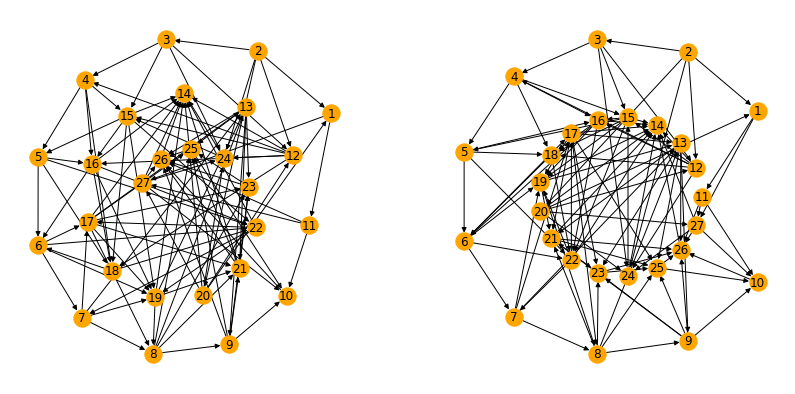

In [ ]:
plt.figure(figsize=(14,7))

#Plotting graph as spiral
plt.subplot(1,2,1)
pos = spiral(len(robot_ids_1)+1)
graph_edges(solution_edges,node_color='orange',pos=pos)

#Plotting graph as a circle
plt.subplot(1,2,2)
pos = circle(11,24) + circle(len(robot_ids_1)-10,12)
graph_edges(solution_edges,node_color='orange',pos=pos)